In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import xarray as xr
import sys,os,glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(0,'../../../')

from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

# Sampling

`TigressWindSampler` class is a child of `TigressWindModel` class. For sampling, it won't build pdf models, but use the scaling relations and parameters of the model.

In [3]:
import twind

In [4]:
sampler=twind.TigressWindSampler()

## Sampling at a single epoch

For this example, we use

- $\Sigma_{\rm SFR} = 10^{-2} M_\odot{\rm kpc^{-2} yr^{-1}}$,
- area = $1 {\rm kpc}^2$
- dt = 1 Myr

and 

- $m^{\rm cool} = m^{\rm hot} \in (10^1, 10^2, 10^3)M_\odot$


In [5]:
def draw_particle_dist(sfr0,area,dt,masses=[1.e2,1.e3,1.e4]):
    Nm=len(masses)
    fig, axes = plt.subplots(1,Nm,figsize=(3*Nm,3))

    for ax, m in zip(axes,masses):

        cool,hot=sampler.draw_mass(sfr0,m,m,area=area,dt=dt)

        plt.sca(ax)

        plt.plot(cool['vz'],cool['cs'],marker='o',ls='',ms=5,alpha=0.5,mew=0)
        plt.plot(hot['vz'],hot['cs'],marker='o',ls='',ms=5,alpha=0.5,mew=0)
        
        plt.xscale('log')
        plt.yscale('log')
        plt.title(r'$m = 10^{:.0f} M_\odot$'.format(np.log10(m)))
        ax.grid('on')
        ax.set_aspect('equal')
        plt.xlim(1.,5.e3)
        plt.ylim(1.,5.e3)
        plt.xlabel(r'$u=\log v_{\rm out}$')
        plt.ylabel(r'$w=\log c_s$')
        plt.tight_layout()
    return fig

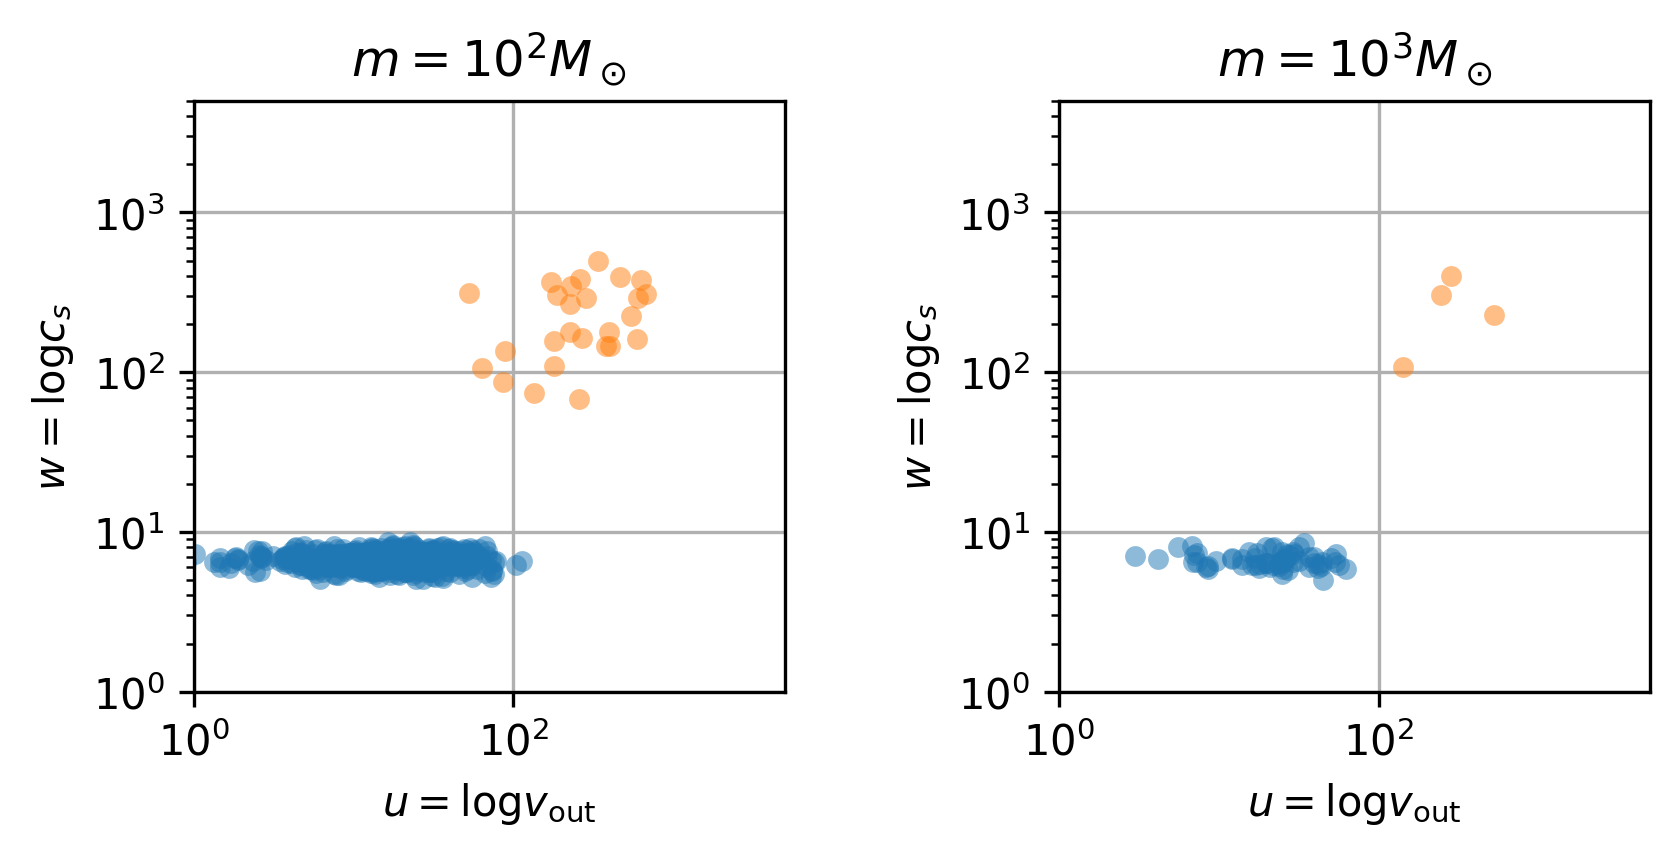

In [6]:
sfr0 = 1.e-2
area = 1
dt = 1.e6

f = draw_particle_dist(sfr0,area,dt,masses=[1.e2,1.e3])

The mass in the outflow can be obatined by
$$ M_{\rm out} = \eta_M \Sigma_{\rm SFR} A dt$$
For a chosen $\Sigma_{\rm SFR}$, the total, cool, and hot mass loading factors are

In [7]:
etaM=sampler._eta_sfr_scaling(sfr0,'M_total')
etaMc=sampler._eta_sfr_scaling(sfr0,'M_cool')
etaMh=sampler._eta_sfr_scaling(sfr0,'M_hot')
print(etaM, etaMc, etaMh)

7.073147336500111 6.543468427172779 0.19266640580154454


which give the outflowing mass in each phase

In [8]:
print(etaM*sfr0*area*dt,etaMc*sfr0*area*dt,etaMh*sfr0*area*dt)

70731.47336500112 65434.68427172778 1926.6640580154453


Therefore, even for $m^{\rm hot}=10^3 M_\odot$, we expect to sample a few particles as shown in the right panel of the above figure.

## Sampling from a time series

For this example, we use a sinusoidal function for SFR surface density time series for 200 Myr with
- mean $\Sigma_{\rm SFR} = 10^{-3} M_\odot{\rm kpc^{-2} yr^{-1}}$,
- period of 50 Myr



In [9]:
tmax = 2.e8
dt = 1.e6
time = np.arange(0,tmax,dt)
tp = 5.e7
sfr0 = 2.e-3
area = 1

sfr=sfr0*0.5*(np.sin(2*np.pi/tp*time)+2)

For a given time series of $\Sigma_{\rm SFR}$, we get reference values of outflow rates using the scaling relations of outflow loading factors (of each outflow phase) presented in [Paper I](link).

`get_refs` method returns four lists containing time series of reference outflow rates and loading factors for total, cool, and hot outflows. Each list contains `mass`, `momemtum`, `energy`, and `metal` in order.

In [10]:
refs,eta,etac,etah = sampler.get_refs(sfr)

In [11]:
mout = [eta[0]*refs[0]*area*dt, etac[0]*refs[0]*area*dt, etah[0]*refs[0]*area*dt]
Eout = [eta[2]*refs[2]*area*dt, etac[2]*refs[2]*area*dt, etah[2]*refs[2]*area*dt]
print('mean outflowing mass = {:.3g} (total) {:.3g} (cool)  {:.3g} (hot) Msun'.format(mout[0].mean(),mout[1].mean(),mout[2].mean()))
print('mean outflowing energy = {:.3g} (total) {:.3g} (cool) {:.3g} (hot) erg'.format(Eout[0].mean(),Eout[1].mean(),Eout[2].mean()))

mean outflowing mass = 2.73e+04 (total) 2.62e+04 (cool)  429 (hot) Msun
mean outflowing energy = 2.16e+51 (total) 4.3e+50 (cool) 1.82e+51 (hot) erg


For the area of 1 kpc$^2$ and time interval 1 Myr considered here, we expect the mean mass and energy in outflow are 1.8e4 Msun and 1.e51 erg, respectively. The mass ratio between cool and hot outflows is about 50, therefore, for fair sampling, we might need $m^{\rm cool}/m^{\rm hot}\sim50$ with $m^{\rm cool}<10^4 M_\odot$.

In [12]:
def draw_particle_time_series(time, sfr, mc, mh, area, dt):
    refs,eta,etac,etah = sampler.get_refs(sfr)
    cool,hot=sampler.draw_mass(sfr,mc,mh,area=area,dt=dt)

    fig,axes = plt.subplots(4,1,sharex=True,figsize=(5,8))
    for p, etas_ in zip([cool,hot],[etac,etah]):
        outs=twind.to_time_series(p,time)

        for ax, q, qref, eta in zip(axes,outs,refs,etas_):
            plt.sca(ax)
            l,=plt.plot(time,q)       
            plt.plot(time,eta*qref*area*dt,color=l.get_color(),ls='--')
            plt.yscale('log')

    axes[0].set_title(r'$m^{{\rm cool}} = 10^{}, m^{{\rm hot}} = 10^{}$'.format(int(np.log10(mc)),int(np.log10(mh))))
    axes[0].set_ylabel('Mass')
    axes[1].set_ylabel('Momentum')
    axes[2].set_ylabel('Energy')
    axes[3].set_ylabel('Metal Mass')
    return fig

Frist, as a well sampled example, we use 
- $m^{\rm cool} = 10^3 M_\odot$
- $m^{\rm hot} = 10^1 M_\odot$

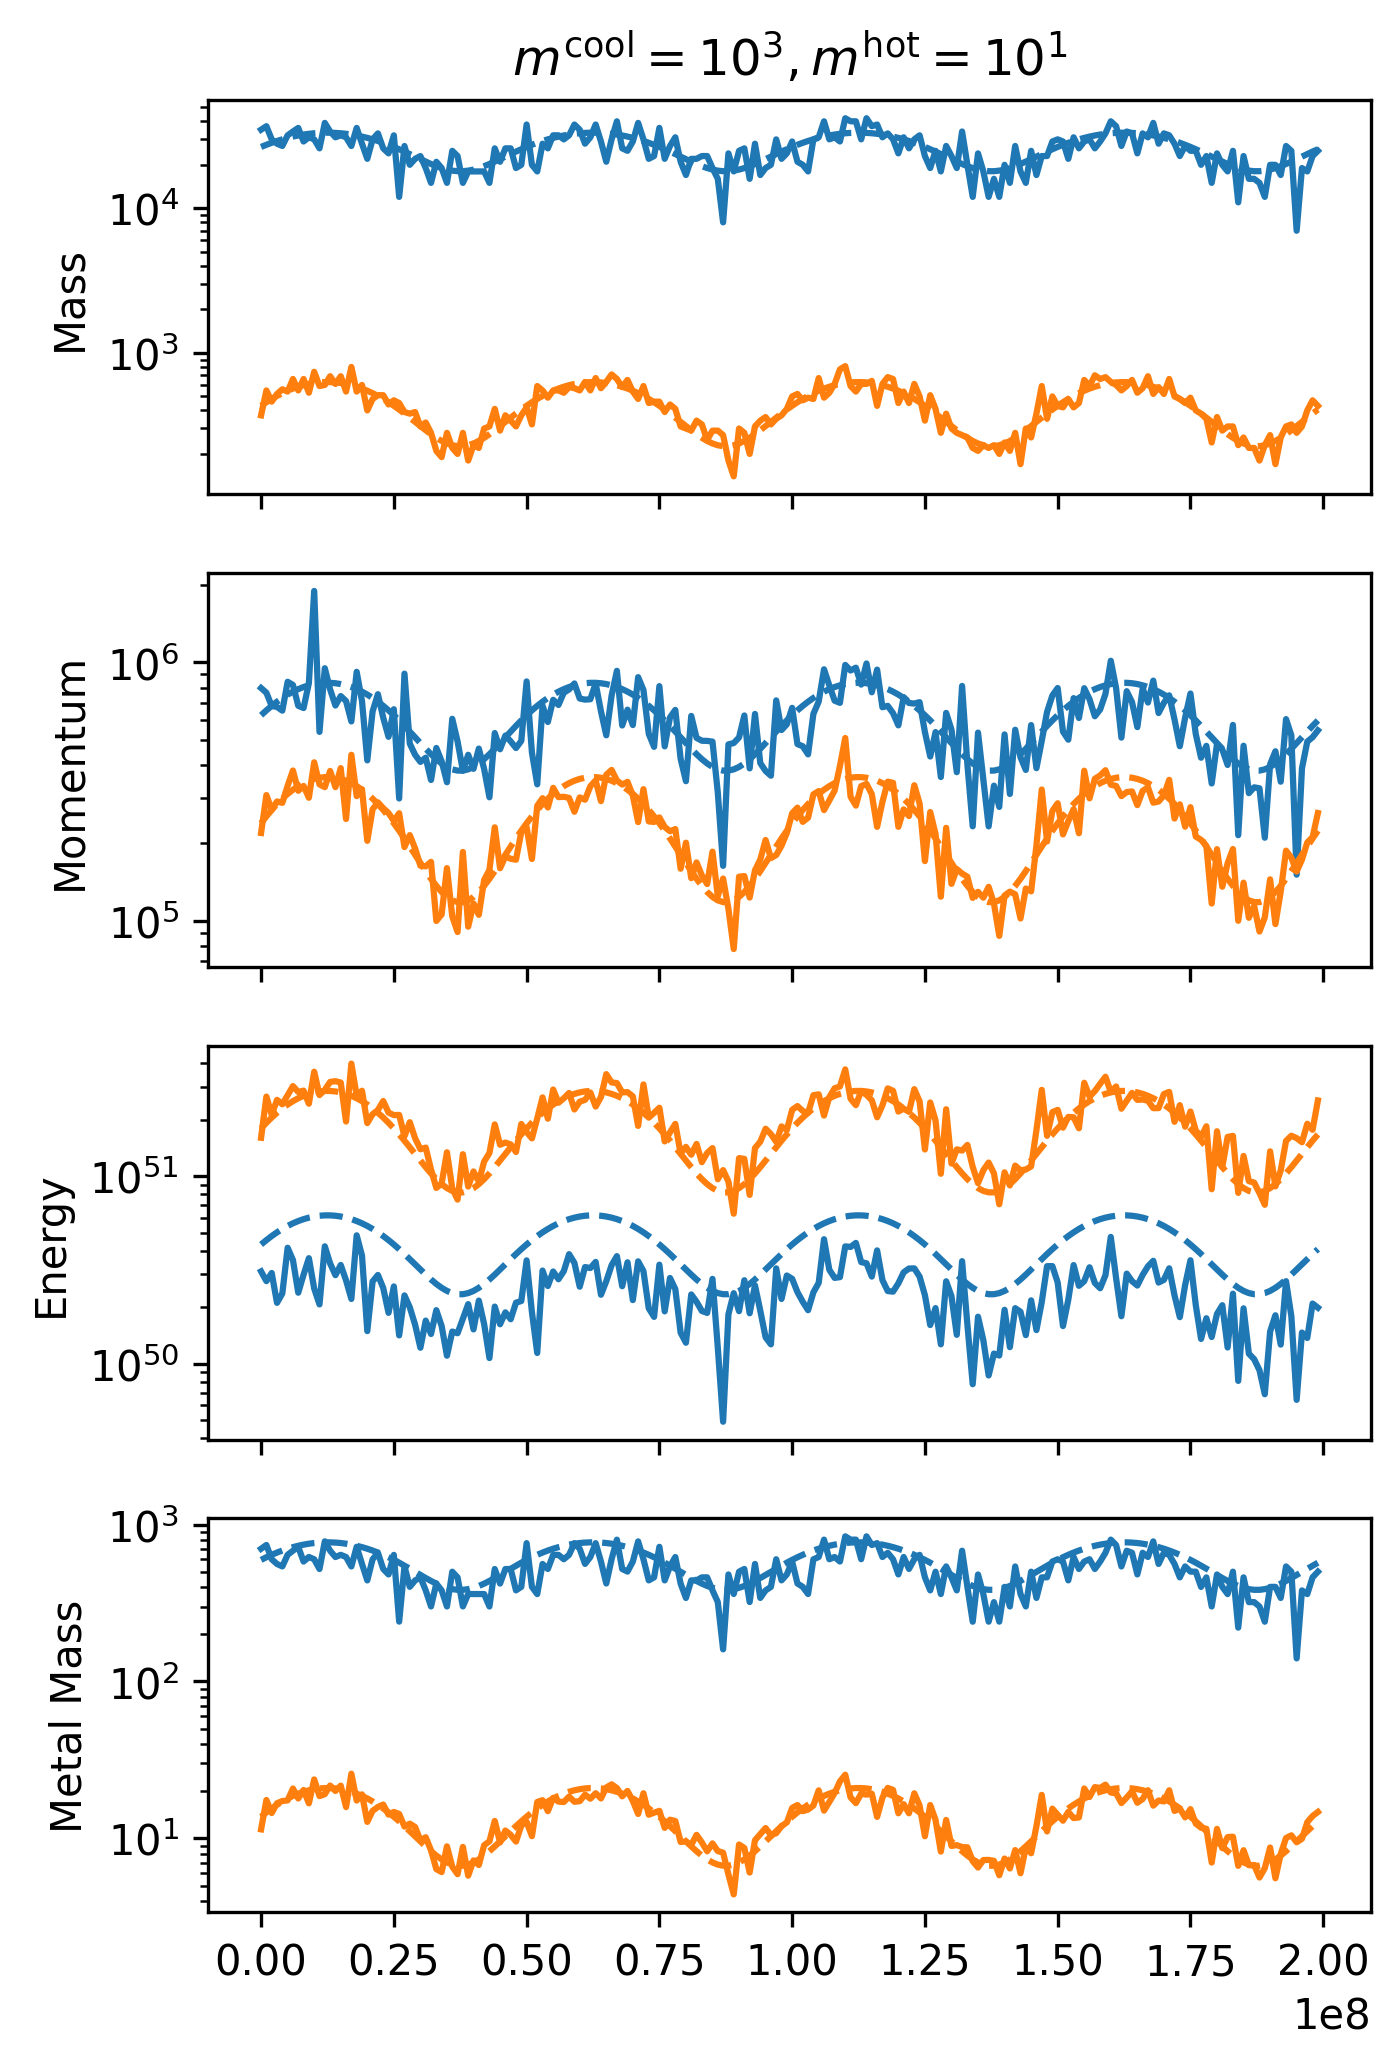

In [13]:
f = draw_particle_time_series(time, sfr, 1.e3, 1.e1, area, dt)

The second example is for well sampled cool phase but poorly sampled hot phase.
- $m^{\rm cool} = 10^3 M_\odot$
- $m^{\rm hot} = 10^3 M_\odot$

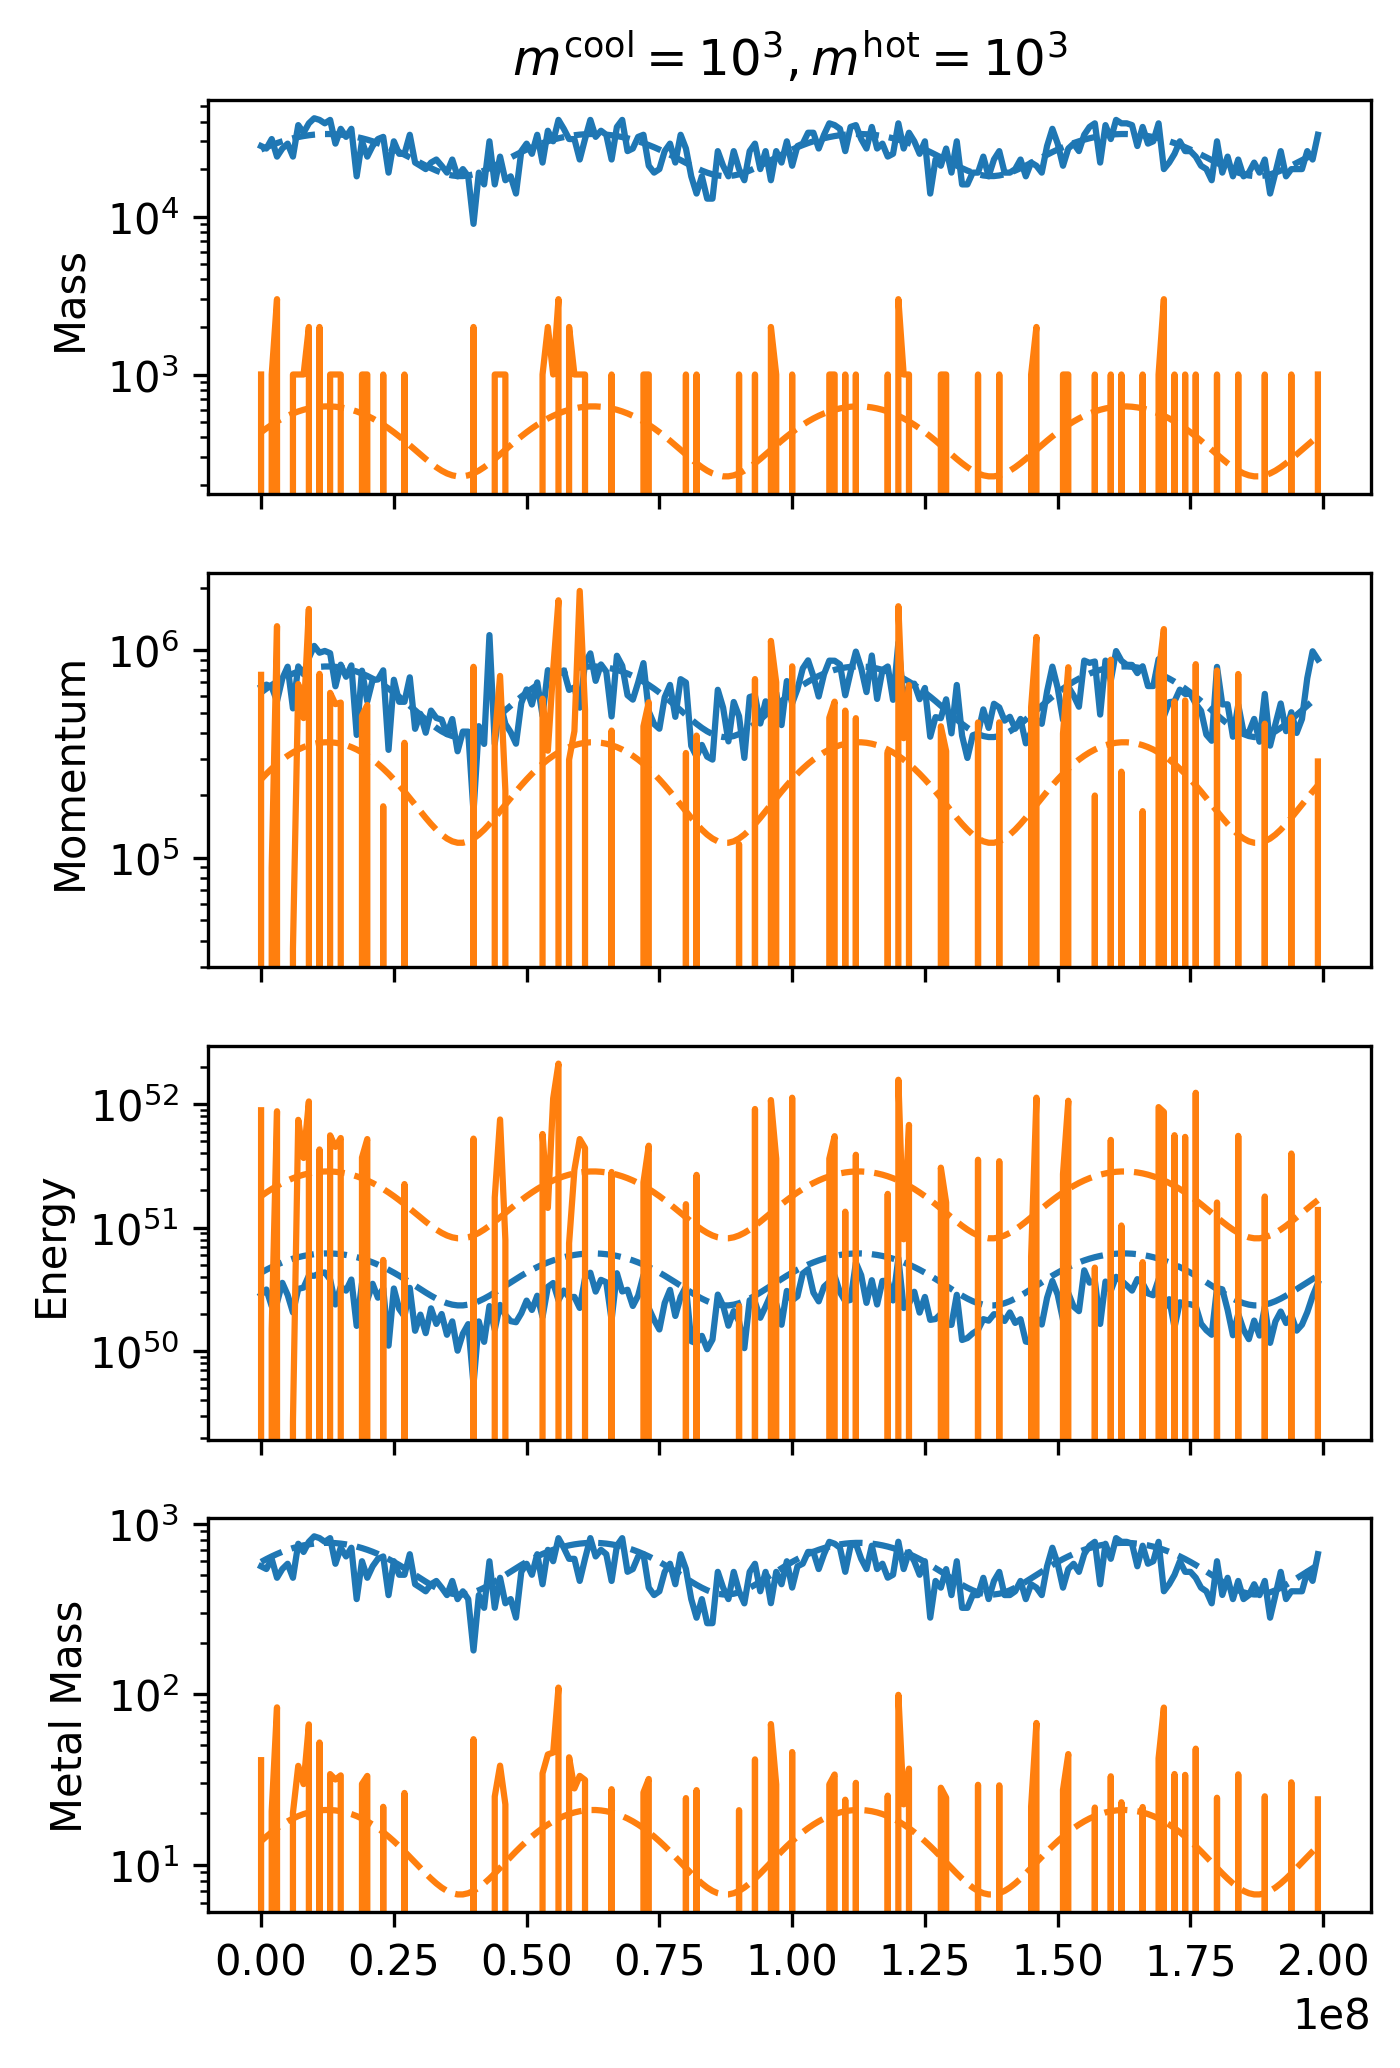

In [14]:
f = draw_particle_time_series(time, sfr, 1.e3, 1.e3, area, dt)